ФИО Ковалишин Никита Игоревич

Группа ML-22

# Условие задания

Обучить бинарный классификатор на основе сверточных нейронных сетей для датасета.
- Вы вольны выбирать любое количество слоёв, подбирать гиперпараметры, выбирать оптимизатор, функцию ошибки итд.    
- Можете разбивать на train-val-test исходя из того, как думаете, что будет лучше.

4 балла:
- Модель должна работоспособна, воспроизводима, код должен быть читаемым;
- Метрика качества accuracy должна быть не ниже 0.9;
- Процесс схождения должен быть залогирован (хотя бы просто графиками в matplotlib, но желательно втч. и в Tensorboard/ClearML/...).

5 баллов:
- Всё то же самое, что на 4 балла, но выполнены подзадания 1, 2 и 3, а метрика качества accuracy должна быть не ниже 0.95.



Подзадания:

1) Выведите кол-во обучаемых параметров сети;    
2) Напишите несколько предложений выводов - что помогло в решении и повысило качество, что нет.    
3) Посчитайте F1-score на тестовой подвыборке.

По желанию к выполнению, в разбалловке не учитывается:     
3) Выведите confusion matrix для тестовой подвыборки;    

# 0) Подготовка необходимых библиотек и функций

In [ ]:
from google.colab import drive, output
import os
import torch
from shutil import make_archive
from torch import nn
from torch.nn import BCELoss
from torch.optim import Adam
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision.io import decode_image
from torchvision.utils import save_image
from matplotlib import pyplot as plt

Вспомогательная функция для вывода изображений:

In [ ]:
def PlotImageFromTensor(img, title=None):
  plt.imshow(img.permute(1, 2, 0))
  plt.title(title)

# 1) Изначальная подготовка данных

### 1.1) Распаковка предварительно разбитых датасетов оригинальных изображений из гугл-диска:

In [ ]:
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/indoor_outdoor_dataset/indoor_outdoor_dataset_train.zip'
!unzip '/content/drive/MyDrive/indoor_outdoor_dataset/indoor_outdoor_dataset_val.zip'
!unzip '/content/drive/MyDrive/indoor_outdoor_dataset/indoor_outdoor_dataset_test.zip'
output.clear()

### 1.2) Обзор пропорций оригинального датасета:

In [ ]:
#train proportions
trainIndoorSamplesCount = len(os.listdir('/content/indoor_outdoor_dataset_train/indoor/'))
trainOutdoorSamplesCount = len(os.listdir('/content/indoor_outdoor_dataset_train/outdoor/'))
#val proportions
valIndoorSamplesCount = len(os.listdir('/content/indoor_outdoor_dataset_val/indoor/'))
valOutdoorSamplesCount = len(os.listdir('/content/indoor_outdoor_dataset_val/outdoor/'))
#test proportions
testIndoorSamplesCount = len(os.listdir('/content/indoor_outdoor_dataset_test/indoor/'))
testOutdoorSamplesCount = len(os.listdir('/content/indoor_outdoor_dataset_test/outdoor/'))

trainSamplesCount = trainOutdoorSamplesCount + trainIndoorSamplesCount
valSamplesCount = valOutdoorSamplesCount + valIndoorSamplesCount
testSamplesCount = testOutdoorSamplesCount + testIndoorSamplesCount
allSamplesCount = trainIndoorSamplesCount + trainOutdoorSamplesCount + \
 valIndoorSamplesCount + valOutdoorSamplesCount + \
 testIndoorSamplesCount + testOutdoorSamplesCount

print(f"Train indoor samples count: {trainIndoorSamplesCount} elements;")
print(f"Train outdoor samples count: {trainOutdoorSamplesCount} elements;")
print(f"Train samples count: {trainSamplesCount} elements.\n")

print(f"Validation indoor samples count: {valIndoorSamplesCount} elements;")
print(f"Validation outdoor samples count: {valOutdoorSamplesCount} elements;")
print(f"Validation samples count: {valSamplesCount} elements.\n")

print(f"Test indoor samples count: {testIndoorSamplesCount} elements;")
print(f"Test outdoor samples count: {testOutdoorSamplesCount} elements;")
print(f"Test samples count: {testSamplesCount} elements.\n")

print("Distribution of the proportions percentage ratios:")
print(f"train: {((1. * trainSamplesCount / allSamplesCount) * 100):.3f} percent,")
print(f"val: {((1. * valSamplesCount / allSamplesCount) * 100):.3f} percent,")
print(f"test: {((1. * testSamplesCount / allSamplesCount) * 100):.3f} percent.\n")

print("Number of batches (batch_size=29):")
print(f"train: {trainSamplesCount / 29} batches,")
print(f"val: {valSamplesCount / 29} batches,")
print(f"test: {testSamplesCount / 29} batches.")

Train indoor samples count: 144775 elements;
Train outdoor samples count: 142557 elements;
Train samples count: 287332 elements.

Validation indoor samples count: 34514 elements;
Validation outdoor samples count: 27082 elements;
Validation samples count: 61596 elements.

Test indoor samples count: 36000 elements;
Test outdoor samples count: 25596 elements;
Test samples count: 61596 elements.

Distribution of the proportions percentage ratios:
train: 69.992 percent,
val: 15.004 percent,
test: 15.004 percent.

Number of batches (batch_size=29):
train: 9908.0 batches,
val: 2124.0 batches,
test: 2124.0 batches.


### 1.3) Обзор трансформаций:

In [ ]:
#Обычная трансформация формата представления изображения (без его фактического изменения)
formatTransform = [v2.ToImage(), v2.ToDtype(torch.float32, scale=True), v2.Resize((256, 256))]
#Рандомно обрезающая трансформация + горизонтальный переворот с вероятностью 0.75
cropFlipTransform = formatTransform + [v2.RandomCrop(160)] + [v2.RandomHorizontalFlip(0.75)] + [v2.Resize(256)]
#рандомные повороты на +-60 градусов
rotateTransform = formatTransform + [v2.RandomRotation(60)]
#вырезание случайной квадратной области
eraseTransform = formatTransform + [v2.RandomErasing(p=1)]

Вывод примера оригинального изображения:

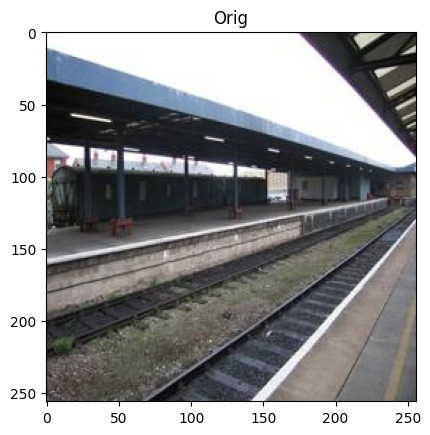

In [ ]:
imgUInt8 = decode_image('/content/indoor_outdoor_dataset_train/indoor/00001597_275902.jpg')
PlotImageFromTensor(v2.Compose(formatTransform)(imgUInt8), "Orig")

Вывод random cropped + horizontal flipped изображения:

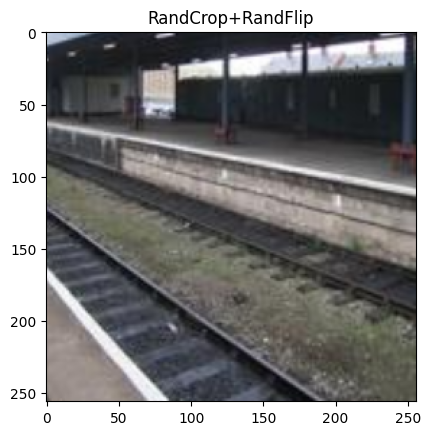

In [ ]:
PlotImageFromTensor(v2.Compose(cropFlipTransform)(imgUInt8), "RandCrop+RandFlip")

Вывод изображения, повёрнутого на случайный угол (в диапазоне +-60 градусов):

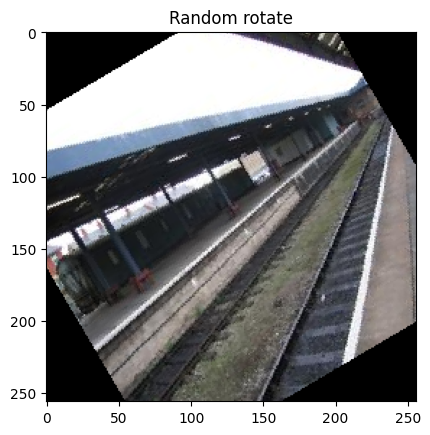

In [ ]:
PlotImageFromTensor(v2.Compose(rotateTransform)(imgUInt8), "Random rotate")

Вывод изображения, из которого вырезается случайный кусок:

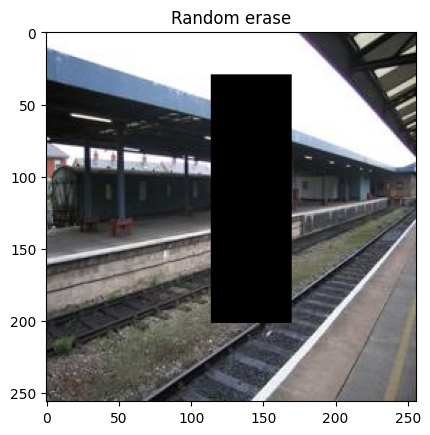

In [ ]:
PlotImageFromTensor(v2.Compose(eraseTransform)(imgUInt8), "Random erase")

### 1.4) Создание образов датасетов и их загрузчиков:

Зная, какие трансформации будут использоваться, следует создать train-образ оригинального датасета и образы фейковых датасетов, основанные на трансформации оригинала:

In [ ]:
#образ оригинального датасета
train_dataset_orig = ImageFolder('/content/indoor_outdoor_dataset_train/', v2.Compose(formatTransform))
#образы фейковых датасетов, соответствующие определённому виду трансформации оригинала:
fake_dataset_cropFlip = ImageFolder('/content/indoor_outdoor_dataset_train/', v2.Compose(cropFlipTransform))
fake_dataset_rotate = ImageFolder("/content/indoor_outdoor_dataset_train/", v2.Compose(rotateTransform))
fake_dataset_erase = ImageFolder("/content/indoor_outdoor_dataset_train/", v2.Compose(eraseTransform))

Объединение оригинального и фейковых датасетов в датасет с аугментациями:

In [ ]:
train_dataset_full = ConcatDataset([train_dataset_orig, fake_dataset_cropFlip,
                                       fake_dataset_rotate, fake_dataset_erase])
print("Length of full dataset with all augmentations: ", len(train_dataset_full))

Length of full dataset with all augmentations:  1149328


Создание соответствующего загрузчика из образа объединённого датасета:

In [ ]:
train_loader = DataLoader(train_dataset_full, batch_size=464, shuffle=True, num_workers=12)

Тренировочные данные для загрузки в модель подготовлены.

# 2) Построение модели и обучение

### 2.1) Построение модели:

Было решено построить собственный образ модели ImageCNN. В качестве функции активации была выбрана SiLU() (она же swish), так как многие именно её рекомендуют для свёрточных сетей. Да и она по сравнению с той же ReLU() обладает некоторыми преимуществами, связанными с неявной регуляризацией при batch-спуске.

In [ ]:
class ImageCNN(nn.Module):
  def __init__(self):
    super(ImageCNN, self).__init__()
    self.convLayers = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                                    nn.SiLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                    nn.SiLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                    nn.SiLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                    nn.SiLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                                    nn.SiLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
                                    nn.SiLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    )

    self.FC_layers = nn.Sequential(nn.Linear(1024*4*4, 1024),
                                   nn.SiLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(1024, 512),
                                   nn.SiLU(),
                                   nn.Linear(512, 1),
                                   nn.Sigmoid(),
                                  )

  def forward(self, img):
    img = self.convLayers(img)
    img = img.view(img.size(0), -1)
    return self.FC_layers(img)

### 2.2) Создание образов датасетов для валидации и теста

In [ ]:
val_dataset = ImageFolder('/content/indoor_outdoor_dataset_val/', v2.Compose(formatTransform))
test_dataset = ImageFolder('/content/indoor_outdoor_dataset_test/', v2.Compose(formatTransform))

val_loader = DataLoader(val_dataset, batch_size = 116, shuffle = True, num_workers=12)
test_loader = DataLoader(test_dataset, batch_size = 116, shuffle = True, num_workers=12)

### 2.3) Функция для обучения и валидации:

In [ ]:
def TrainAndValidation(train_loader, val_loader, model, criterion, optimizer, device, n_iters = 10):
  model = model.to(device)
  criterion = criterion.to(device)
  trainLossLst = []
  trainAccuracyLst = []
  valLossLst = []
  valAccuracyLst = []
  for epoch in range(n_iters):
    model.train()
    trainLossLst += [0]
    trainAccuracyLst += [0]
    for features, targets in train_loader:
      optimizer.zero_grad(set_to_none=True)
      features = features.to(device)
      targets = targets.to(device).float().view(-1, 1)
      predProbs = model(features)
      loss = criterion(predProbs, targets)
      loss.backward()
      optimizer.step()
      trainLossLst[-1] += loss.item()
      trainAccuracyLst[-1] += torch.sum((predProbs >= 0.5).float() == targets).float() / train_loader.batch_size
    trainLossLst[-1] /= len(train_loader) #учитывается то, что кол-во семплов во всём train'e делится нацело на размер batch'а
    trainAccuracyLst[-1] /= len(train_loader)
    print(f"Train Loss {epoch}: {trainLossLst[-1]}")
    print(f"Train Accuracy {epoch}: {trainAccuracyLst[-1]}\n")
    #валидация
    model.eval()
    valLossLst += [0]
    valAccuracyLst += [0]
    with torch.no_grad():
      for v_features, v_targets in val_loader:
        v_features = v_features.to(device)
        v_targets = v_targets.to(device).float().view(-1, 1)
        v_predProbs = model(v_features)
        valLossLst[-1] += criterion(v_predProbs, v_targets)
        valAccuracyLst[-1] += torch.sum((v_predProbs >= 0.5).float() == v_targets) / val_loader.batch_size
    valLossLst[-1] /= len(val_loader)
    valAccuracyLst[-1] /= len(val_loader)
    print(f"Validation Loss {epoch}: {valLossLst[-1]}")
    print(f"Validation Accuracy {epoch}: {valAccuracyLst[-1]}\n")
    if valAccuracyLst[-1] >= 0.95: # примитивный критерий остановки
      break
  return (trainLossLst, trainAccuracyLst), (valLossLst, valAccuracyLst)



### 2.4) Проверка подключения нужного устройства:

In [ ]:
print("Device connected: ", torch.cuda.get_device_name())

Device connected:  NVIDIA A100-SXM4-40GB


### 2.5) Запуск процесса обучения и валидации

In [ ]:
model = ImageCNN()
optimizer = Adam(model.parameters(), lr=0.0002)
loss = BCELoss() #вероятность совпадения результата с одного семпла с y_train[i] (p^y)*(1-p)^(1-y)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainResults, valResults = TrainAndValidation(train_loader, val_loader, model, loss, optimizer, device, n_iters=50)#4564

Train Loss 0: 0.3632161304456936
Train Accuracy 0: 0.8402820229530334

Validation Loss 0: 0.2845565974712372
Validation Accuracy 0: 0.8861287236213684

Train Loss 1: 0.28852477665504817
Train Accuracy 1: 0.880470335483551

Validation Loss 1: 0.22833262383937836
Validation Accuracy 1: 0.9103028774261475

Train Loss 2: 0.25820342131593704
Train Accuracy 2: 0.8948778510093689

Validation Loss 2: 0.21175603568553925
Validation Accuracy 2: 0.9179982542991638

Train Loss 3: 0.23363682359372795
Train Accuracy 3: 0.9056578874588013

Validation Loss 3: 0.19875772297382355
Validation Accuracy 3: 0.922690212726593

Train Loss 4: 0.21170408244714364
Train Accuracy 4: 0.9156184792518616

Validation Loss 4: 0.18864619731903076
Validation Accuracy 4: 0.9302231669425964

Train Loss 5: 0.19162035051870116
Train Accuracy 5: 0.9241800904273987

Validation Loss 5: 0.17923183739185333
Validation Accuracy 5: 0.9339576959609985

Train Loss 6: 0.17210658812924745
Train Accuracy 6: 0.9321437478065491

Validati

Если судить по логу выше, то максимальный показатель accuracy на валидации составляет примерно 0.9488 или 94.88%, что приблизительно можно считать как 95%.

### 2.6) Построение графика сходимости на основе полученных результатов на train'e и валидации:

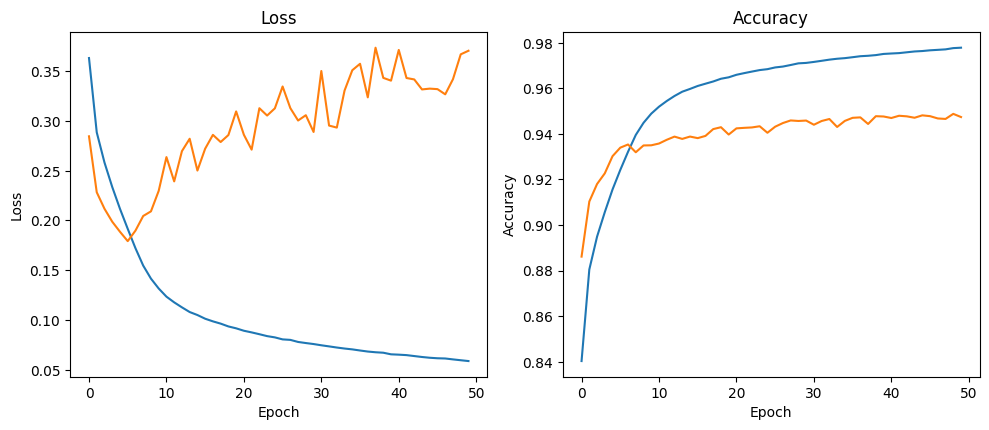

In [ ]:
for i in range(len(valResults[0])):
  valResults[0][i] = valResults[0][i].to("cpu")#234
for i in range(len(valResults[1])):
  valResults[1][i] = valResults[1][i].to("cpu")
for i in range(len(valResults[1])):
  trainResults[1][i] = trainResults[1][i].to("cpu")
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(trainResults[0], label='trainLoss')
plt.plot(valResults[0], label='valLoss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(trainResults[1], label='trainAcc')
plt.plot(valResults[1], label='valAcc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.tight_layout()

plt.show()

 Я специально поставил больше итераций, чем нужно, чтобы увидеть как сеть ведёт себя на валидации.

 По графику Loss можно заметить, что за 50 итераций нейронная сеть обнаружила какую-то закономерность на тестовой выборке, которая в общем случае касательно определения класса считается неверной. Грубо говоря, начиная с 6-й итерации пошёл процесс переобучения, и нейронная сеть стала излишне уверенной в какой-то неправильной закономерности. Точнее так, она как бы для видимых данных правильная, а для невидимых не правильная. Поэтому её результат начинает сильно зависеть от того, есть ли эта закономерность в невидимых данных или нет. Если её нет, то результаты могут быть значительно хуже.

 Возможно нужно провести дополнительные аугментации, возможно, нужно дополнительно почистить данные, так как наверняка присутствуют выбросы или ошибочная разметка.

 Поэтому в общем случае хорошо было бы остановить обучение на 6-й итерации, где у нас наблюдается минимум по валидационному Loss. Для невидимых данных эта модель была бы самой оптимальной. На 6-й итерации, кстати, Accuracy = 93,5%, что тоже не плохо.

 Но тем не менее, по графику видно, что Accuracy на валидации в целом стабилизируется на отметке 0.949-0.95. Значит, по мере обучения нейронная сеть всё-таки постепенно но угадывает всё большую часть правильных ответов на валидации, но уже с трудом.

### 2.7) Анализ ошибок переобученной нейросети (в скобках, что предсказала нейросеть 0 - indoor, 1 - outdoor)

Предварительно скажу, что нейросеть ошибается на данных, которые либо неправильно размечены, либо даже человеку с трудом можно понять, где снято фото. Но есть и правильные семплы, где нейросеть не должна ошибаться, а она ошибается.

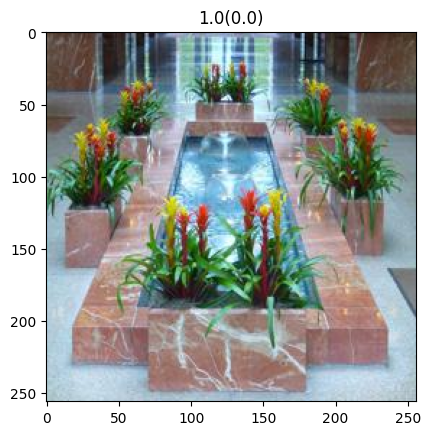

In [ ]:
image0 = mistakeFeaturesLst[0][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image0, f"{targetsLst[0][0].item()}({mistakeOutputsLst[0]})")

**Нулевая картинка.** Вот мне, если честно не понятно, внутри ли это или снаружи. Не хватает информации о потолках, окнах. То есть по картинке нельзя однозначно сказать, что это outdoor

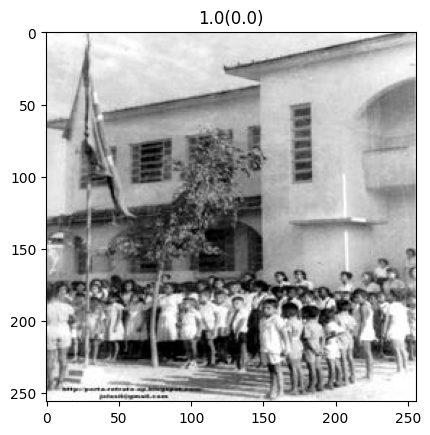

In [ ]:
image1 = mistakeFeaturesLst[1][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image1, f"{targetsLst[1][0].item()}({mistakeOutputsLst[1]})")

**Первая картинка.** Вот здесь уже нейросеть дала действительно неправильное предсказание. Возможно из-за того, что в картинке не прорисована достаточная глубина. Это уже даёт нам понять, что нейросеть переобучилась определять outdoor по глубине картинки.

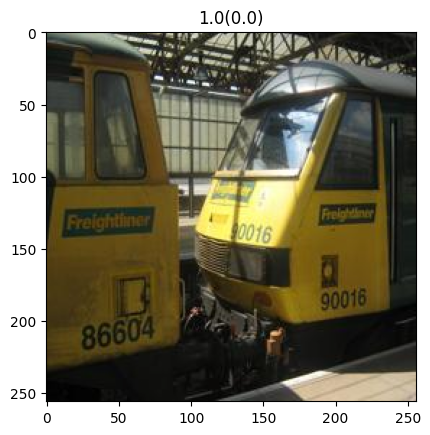

In [ ]:
image2 = mistakeFeaturesLst[2][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image2, f"{targetsLst[2][0].item()}({mistakeOutputsLst[2]})")

**Вторая картинка.** Как я понимаю, это крытый вокзал. Но на картинке не видно никакой информации, что это снаружи помещения. Всё вокруг в стенах, есть лишь луч солнца, падающий на поезд. Но видимо нейросеть этого не посчитала достаточным основанием сказать, что это outdoor. Условно, если бы не было нарисовано поезда и железной дороги, то и человек бы смог ошибиться.

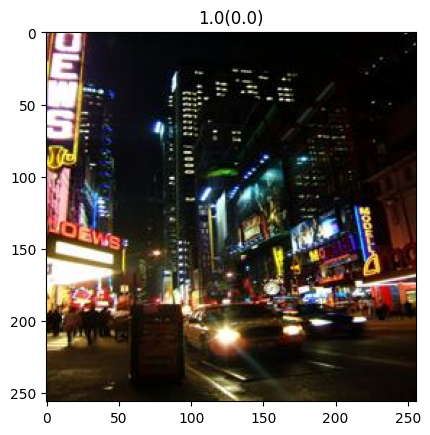

In [ ]:
image3 = mistakeFeaturesLst[3][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image3, f"{targetsLst[3][0].item()}({mistakeOutputsLst[3]})")

**Третья картинка.** Здесь тёмное время суток в мегаполисе. Нейросеть уверенно ошиблась, это значит, что скорее всего она переобучилась определять outdoor по наличию светлых оттенков на фотографии.

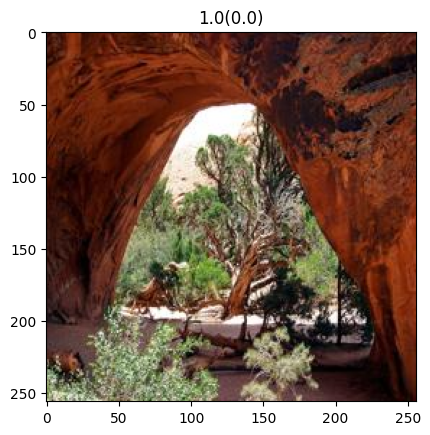

In [ ]:
image4 = mistakeFeaturesLst[4][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image4, f"{targetsLst[4][0].item()}({mistakeOutputsLst[4]})")

**Четвёртая картинка.** Здесь фото арки вблизи. Видимо, нейросеть подумала, что фото сделано изнутри пещеры...

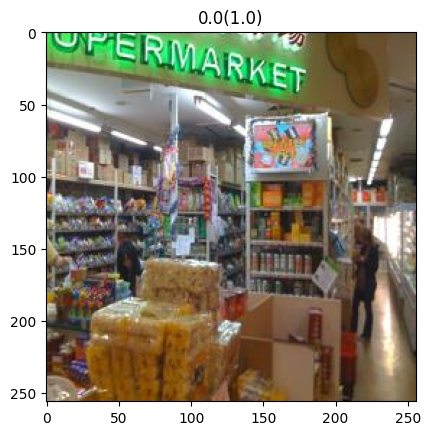

In [ ]:
image5 = mistakeFeaturesLst[5][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image5, f"{targetsLst[5][0].item()}({mistakeOutputsLst[5]})")

**Пятая картинка.** А вот здесь уже преимущественно светлые оттенки + глубина какая-то имеется, и нейросеть оэидаемо ответила неверно, что это outdoor.

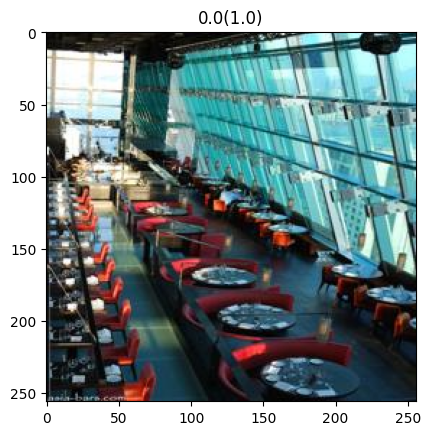

In [ ]:
image6 = mistakeFeaturesLst[6][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image6, f"{targetsLst[6][0].item()}({mistakeOutputsLst[6]})")

**Шестая картинка** - аналогично пятой.

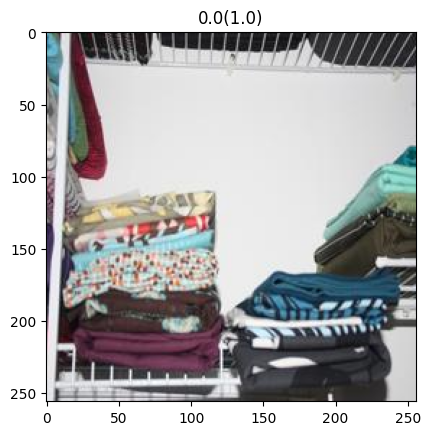

In [ ]:
image7 = mistakeFeaturesLst[7][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image7, f"{targetsLst[7][0].item()}({mistakeOutputsLst[7]})")

**Седьмая картинка.** А вот здесь уже неприемлемая ошибка. Получается, что нейросеть действительно делает сильный акцент на светлых цветах. Но какую же тогда аугментацию придумать, я не знаю...

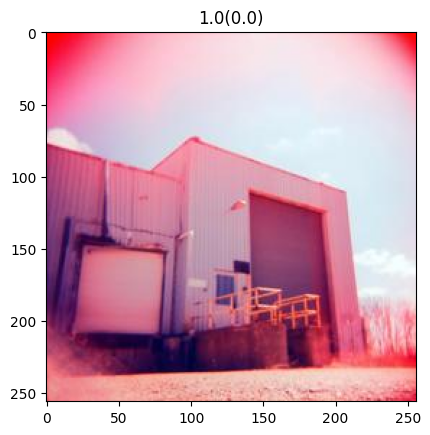

In [ ]:
image8 = mistakeFeaturesLst[8][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image8, f"{targetsLst[8][0].item()}({mistakeOutputsLst[8]})")

**Восьмая картинка.** А вот здесь интересная ошибка. Видимо из-за того, что по углам виднеются затемнения нейронная сеть подумала, что это сделано внутри помещения... То есть углы картинки нейронной сетью прямо сильно берутся во внимание. Что доказывает ещё и 4-я картинка.

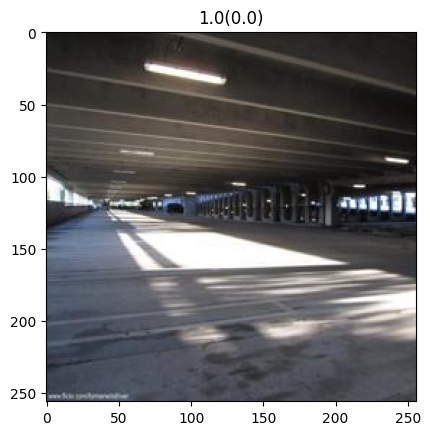

In [ ]:
image9 = mistakeFeaturesLst[9][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image9, f"{targetsLst[9][0].item()}({mistakeOutputsLst[9]})")

**Девятая картинка.** Если логически подумать, то парковку можно считать как indoor, так и outdoor. То есть однозначно сказать нельзя.

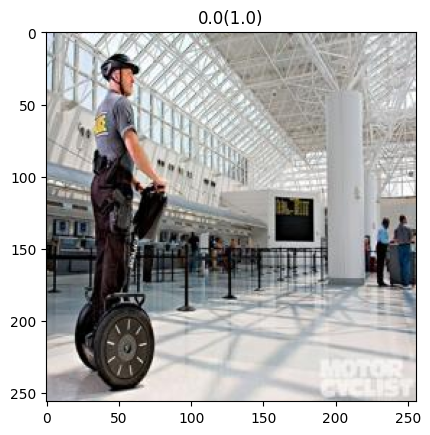

In [ ]:
image10 = mistakeFeaturesLst[10][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image10, f"{targetsLst[10][0].item()}({mistakeOutputsLst[10]})")

**Десятая картинка.** Ну здесь опять светлые тона...

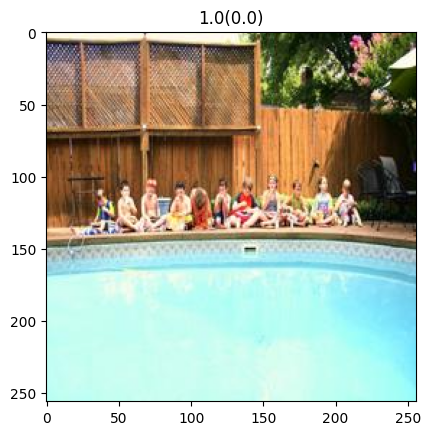

In [ ]:
image11 = mistakeFeaturesLst[11][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image11, f"{targetsLst[11][0].item()}({mistakeOutputsLst[11]})")

**Одиннадцатая картинка.** Здесь не хватает глубины, как в обычных картинках outdoor есть.

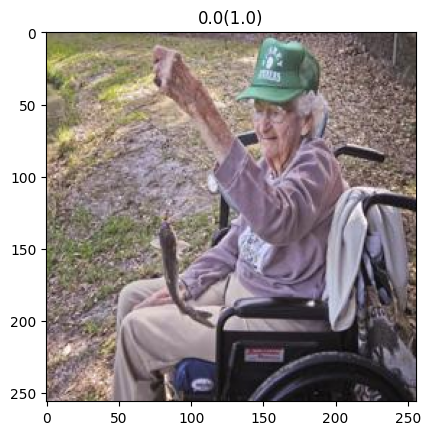

In [ ]:
image12 = mistakeFeaturesLst[12][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image12, f"{targetsLst[12][0].item()}({mistakeOutputsLst[12]})")

**Двенадцатая катинка.** Ну здесь явно изначальная разметка неправильная. Нейросеть предсказала правильно, что это outdoor. Рыбачат же не внутри помещения. Но в разметке указано - indoor.

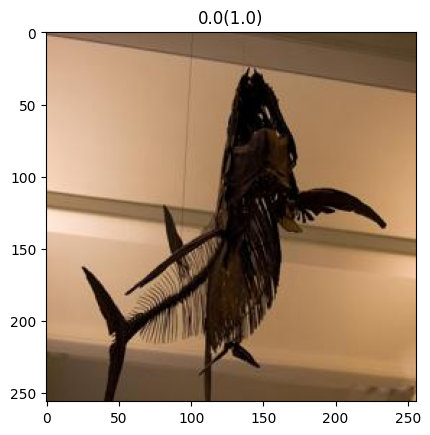

In [ ]:
image13 = mistakeFeaturesLst[13][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image13, f"{targetsLst[13][0].item()}({mistakeOutputsLst[13]})")

**Тринадцатая картинка.** Здесь светлые тона, нейросеть предсказала outdoor.

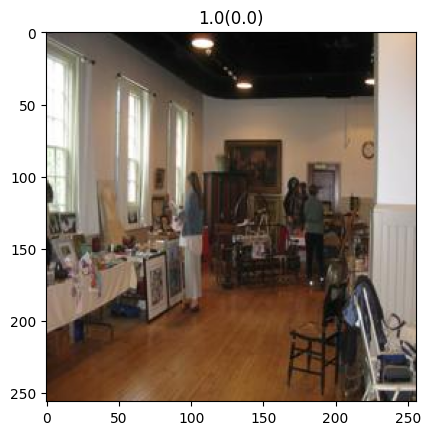

In [ ]:
image14 = mistakeFeaturesLst[14][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image14, f"{targetsLst[14][0].item()}({mistakeOutputsLst[14]})")

**Четырнадцатая картинка.** Здесь опять неправильная разметка.

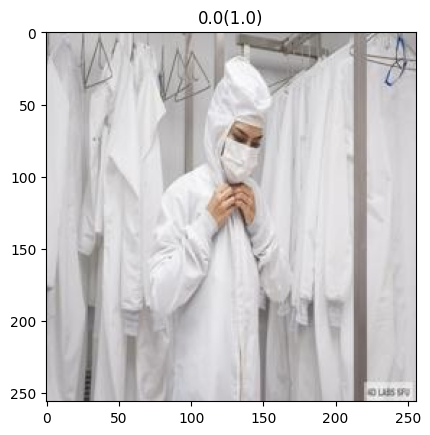

In [ ]:
image15 = mistakeFeaturesLst[15][0].to('cpu')*torch.FloatTensor(testStd).unsqueeze(dim=1).unsqueeze(dim=1) + torch.FloatTensor(testMean).unsqueeze(dim=1).unsqueeze(dim=1)
PlotImageFromTensor(image15, f"{targetsLst[15][0].item()}({mistakeOutputsLst[15]})")

**Пятнадатая картинка.** Ну здесь очевидно, что нейросеть точно берёт белый цвет во внимание, хотя этого она делать не должна.

### 2.8) Проверка модели на тесте

In [ ]:
def check_model(model, test_loader, criterion, device):
  model.eval()
  model = model.to(device)
  test_loss = 0
  test_accuracy = 0
  TP = 0
  FP = 0
  FN = 0
  with torch.no_grad():
    for t_features, t_targets in test_loader:
      t_features = t_features.to(device)
      t_targets = t_targets.to(device).float().view(-1, 1)
      t_predProbs = model(t_features)
      test_loss += criterion(t_predProbs, t_targets)
      test_accuracy += torch.sum((t_predProbs >= 0.5).float() == t_targets).float() / test_loader.batch_size
      t_outputs = (t_predProbs >= 0.5).float().view(-1)
      t_targets = t_targets.view(-1)
      TP += torch.sum(t_outputs * t_targets)
      FP += torch.sum(t_outputs * (t_targets == 0.0).float())
      FN += torch.sum((t_outputs == 0).float() * t_targets)
  test_loss /= len(test_loader)
  test_accuracy /= len(test_loader)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  print(f"Test Loss: {test_loss}")
  print(f"Test Accuracy: {test_accuracy}\n")
  print(f"F1 score: {2 * precision * recall / (precision + recall)}\n")

In [ ]:
check_model(model, test_loader, loss, device)

Test Loss: 0.39325639605522156
Test Accuracy: 0.9490563273429871

F1 score: 0.9390182495117188



Как видно, по результатам мы практически приблизились к показателю accuracy = 0.95 как на тестовой выборке (здесь accuracy = 0.949), так и на валидации (там на валидации макс. accuracy = 0.9488 на 48-й эпохе). При этом использовалась своя реализация свёрточной сети ImageCNN.

### 2.9) Количество параметров модели

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print('Model parameters count:', total_params)

Model parameters count: 23591745


#3) Выводы

0) Очевидно, что наша нейросеть переобучилась, и стала выделять закономерности, которые не являются общими для всех классов. Например, светлые тона для outdoor, отсутствие границ по краям картинки для outdoor, большая глубина картинки для outdoor или маленькая для indoor. Все эти признаки наверняка встречались в train'e в большинстве и соответствовали конкретным классам. А таких картинок как ночной город или арка, или поезд с парковкой встречалось мало(. Проведённых аугментаций явно не хватило. Возможно стоило бы провести ещё рамочную аугментацию, то есть окаймить картинки какой-то рамкой. Но в целом, мне кажется, что и сама модель явно должна была бы иметь получше архитектуру. Как у той же ResNet, например, где есть skip connection'ы.

1) На валидации и на тесте получен accuracy в районе 95%, что является хорошим показателем.

2) F1-score на тесте получился в районе 0.94, что является отличным показателем.

3) Loss на валидации при обучении стал показывать, что модель нашла какую-то ошибочную закономерность, которая касалась только тренировочного датасета, но не проявлялась на невидимых данных.

4) Мне помогло немного улучшить скор замена функции активации с ReLU() на SiLU(). Оно и понятно, ведь SiLU() способствует неявной регуляризации благодаря тому, что в отрицательной части возле нуля есть небольшой ненулевой остаток.

5) Так же мне сильно помогла аугментация (кропы, горизантальное отражение, повороты, ). Можно было бы конечно ещё с яркостью и цветом поэкспериментировать, потому что у меня есть подозрение, что нейронная сеть, в частности, определяет outdoor по объёму белого цвета на картинке. Но что конкретно придумать, я не знаю. Если брать v2.RandomInvert(), то, мне кажется, он через чур перестарается, и может исказить наши результаты. Возможно следовало бы даже упростить наши картинки, использовав понижение глубины цвета, чтобы модель не так обращала внимание на какие-то мелочи. В общем, работать ещё есть куда.

5.1) Немаловажную роль сыграла ещё аугментация на лету (online-аугментация), ведь от эпохи к эпохи у нас генерируются немного разные данные (так как все применённые мной аугментации содержат случайность). Это хорошо, так как при обучении модель не будет подстраиваться под какие-то шумные закономерности, которые могут возникнуть при зафиксированной аугментации, что тоже способствует уменьшению переобучения. Но так же у этого метода есть и недостатки, мы не можем нормализовать тренировочные данные, так как нам на каждой эпохе неизвестны mean и std.

Что мне не помогло, так это аугментация через v2.RandomInvert(...), v2.RandomPosterize(...) и v2.ColorJitter(...). Accuracy с их применением у меня не поднимался выше 93%. Скорее всего они вносят в картинку сильные искажения, которые удаляют некоторые полезные обобщающие закономерности в том числе. А вредные закономерности, которые вообще никак не относятся к классификации, наоборот, могут вносить сильнее. Так что аугментациями сильно увлекаться не стоит.